# Predizione dei noleggi di biciclette

**Programmazione di applicazioni Data Intesive**

Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Matteo Bagnolini

`matteo.bagnolini5@studio.unibo.it`

## Descrizione del problema e analisi del Dataset
Si vuole realizzare un modello di machine learning che, utilizzando alcune informazioni riguardo le condizioni atmosferiche di una città, permetta di predirre il numero di noleggi di biciclette ogni ora.

Vengono importate le librerie fondamentali, che saranno usate in seguito per il caricamento e l'analisi del dataset preso in considerazione.

In [202]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Caricamento del Dataset e preprocessing

In [203]:
import os
from urllib.request import urlretrieve
def download(file, url):
    if not os.path.isfile(file):
        urlretrieve(url, file)

Si è preso come riferimento [questo](https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand) dataset, trovato sulla piattaforma [UCI Machine Learning Repository](https://archive.ics.uci.edu/). Il dataset contiene quasi 9000 righe, con 14 features ognuna. All'interno sono presenti i dati di noleggio di biciclette e delle condizioni atmosferiche della città di Seoul nell'arco temporale di un anno (da dicembre 2017 a dicembre 2018).

In [204]:
dataset_url = "https://archive.ics.uci.edu/static/public/560/seoul+bike+sharing+demand.zip"
zipfile_name = "seoul_bike_sharing_demand.zip"

download(zipfile_name, dataset_url)

from zipfile import ZipFile
with ZipFile(zipfile_name) as f:
    f.extractall()

Per ridurre l'utilizzo di memoria per il dataset scaricato, andiamo a specificare i tipi di dati di ogni variabile. Queste informazioni saranno utili anche successivamente, durante il preprocessing.

In [205]:
types = {
    "Rented Bike Count": int,
    "Hour": int,
    "Temperature(°C)": float,
    "Humidity(%)": float,
    "Wind speed (m/s)": float,
    "Visibility (10m)" : int,
    "Dew point temperature(°C)": float,
    "Solar Radiation (MJ/m2)": float,
    "Rainfall(mm)": float,
    "Snowfall (cm)": float,
    "Seasons": "category",
    "Holiday": "category",
    "Functioning Day": "category",
}

Carichiamo il dataset, specificando i tipi di dati delle variabili.

In [206]:
data = pd.read_csv(
    "SeoulBikeData.csv",
    sep=",",
    encoding='latin-1',
    dtype=types,
    parse_dates=["Date"],
    dayfirst=True,
)

data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-12-01,254,0,-5.2,37.0,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,-5.5,38.0,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,2,-6.0,39.0,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01,107,3,-6.2,40.0,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01,78,4,-6.0,36.0,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


Di seguito sono riportate le dimensioni in memoria, il numero di istanze non nulle e il tipo di ogni feature che compongono i dati all'interno del dataset.

In [207]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8760 non-null   datetime64[ns]
 1   Rented Bike Count          8760 non-null   int64         
 2   Hour                       8760 non-null   int64         
 3   Temperature(°C)            8760 non-null   float64       
 4   Humidity(%)                8760 non-null   float64       
 5   Wind speed (m/s)           8760 non-null   float64       
 6   Visibility (10m)           8760 non-null   int64         
 7   Dew point temperature(°C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)    8760 non-null   float64       
 9   Rainfall(mm)               8760 non-null   float64       
 10  Snowfall (cm)              8760 non-null   float64       
 11  Seasons                    8760 non-null   category      
 12  Holida

Notiamo come nel dataset preso in considerazione non siano presenti valori nulli, quindi tutti i valori sembrerebbero poter essere utilizzabili.

Vediamo anche che i nomi delle variabili sono relativamente complessi (alcuni mostrano l'unità di misura). Queste informazioni non ci serviranno e sono scomode per la scrittura del codice, quindi passiamo a rinominare le features con nomi più significativi.

In [208]:
new_names = {
    "Date": "date",
    "Rented Bike Count": "rented_bike_counts",
    "Hour": "hour",
    "Temperature(°C)": "temperature",
    "Humidity(%)": "humidity",
    "Wind speed (m/s)": "wind_speed",
    "Visibility (10m)" : "visibility",
    "Dew point temperature(°C)": "dew_point_temperature",
    "Solar Radiation (MJ/m2)": "solar_radiation",
    "Rainfall(mm)": "rainfall",
    "Snowfall (cm)": "snowfall",
    "Seasons": "seasons",
    "Holiday": "holiday",
    "Functioning Day": "functioning_day",
}

In [209]:
data = data.rename(columns=new_names)
data.head()

,date,rented_bike_counts,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day
0,2017-12-01,254,0,-5.2,37.0,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,-5.5,38.0,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,2,-6.0,39.0,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01,107,3,-6.2,40.0,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01,78,4,-6.0,36.0,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


Verifichiamo quali valori assumono le variabili categoriche:

In [210]:
data["seasons"].value_counts()

seasons
Spring    2208
Summer    2208
Autumn    2184
Winter    2160
Name: count, dtype: int64

In [211]:
data["holiday"].value_counts()

holiday
No Holiday    8328
Holiday        432
Name: count, dtype: int64

In [212]:
data["functioning_day"].value_counts()

functioning_day
Yes    8465
No      295
Name: count, dtype: int64

Notiamo che sia `functioning_day` e `holiday` assumono solamente due valori differenti, quindi possiamo trasformarle in variabili booleane.

In [213]:
data[["functioning_day", "holiday"]] = data[["functioning_day", "holiday"]].astype("object").replace({"Yes": True, "No": False, "No Holiday": False, "Holiday": True})

/var/folders/dw/rhcd_rk92cz30d_v8c0l4xqm0000gp/T/ipykernel_17778/994866998.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[["functioning_day", "holiday"]] = data[["functioning_day", "holiday"]].astype("object").replace({"Yes": True, "No": False, "No Holiday": False, "Holiday": True})


Per aumentare la leggibilità del dataframe, affianchiamo la colonna `hour` con la colonna `date`.

In [214]:
cols = data.columns.tolist()

cols[1], cols[2] = cols[2], cols[1]

data = data[cols]
data.head()

,date,hour,rented_bike_counts,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day
0,2017-12-01,0,254,-5.2,37.0,2.2,2000,-17.6,0.0,0.0,0.0,Winter,False,True
1,2017-12-01,1,204,-5.5,38.0,0.8,2000,-17.6,0.0,0.0,0.0,Winter,False,True
2,2017-12-01,2,173,-6.0,39.0,1.0,2000,-17.7,0.0,0.0,0.0,Winter,False,True
3,2017-12-01,3,107,-6.2,40.0,0.9,2000,-17.6,0.0,0.0,0.0,Winter,False,True
4,2017-12-01,4,78,-6.0,36.0,2.3,2000,-18.6,0.0,0.0,0.0,Winter,False,True


### Significato delle features

Si riportano l'elenco delle features del dataset, con una breve descrizione.

- `date`: data della misurazione
- `rented_bike_count`: numero di biciclette noleggiate
- `hour`: ora della misurazione
- `temperature`: temperatura registrata (in Celsius)
- `humidity`: umidità relativa (in %)
- `wind_speed`: velocità del vento (in m/s)
- `visibility`. visibilità misurata in decine di metri
- `dew_point_temperature`: temperature di rugiada (in Celsius), indica il punto in cui l'umidità nell'aria condensa
- `solar_radiation`: radiazione solare (in Mj/m^2)
- `rainfall`: precipitazioni piovose (in mm)
- `snowfall`: precipitazioni nevose (in cm)
- `Seasons`: stagione nella quale è stata effettuata la misura (Winter, Spring, Summer, Autumn)
- `holiday`: indica se l'ora è in un giorno festivo o meno
- `functioning_day`: indica se il servizio era funzionante in quell'ora

Come detto in precedenza, l'obiettivo è costruire un modello di regressione che permette di trovare il conteggio di biciclette noleggiate partendo dalle informazioni atmosferiche. Per questo motivo, la variabile `rented_bike_count` sarà la nostra variabile obiettivo.

### Analisi esplorativa delle features

Di seguito eseguiamo un'analisi esplorativa delle features del nostro dataset.

Otteniamo una descrizione generale, con alcune statistiche di base, delle variabili del nostro dataset.

In [215]:
data.describe()

,date,hour,rented_bike_counts,temperature,humidity,wind_speed,visibility,dew_point_temperature,solar_radiation,rainfall,snowfall
count,8760,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2018-05-31 23:59:59.999999744,11.500000,704.602055,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
min,2017-12-01 00:00:00,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,2018-03-02 00:00:00,5.750000,191.000000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,2018-06-01 00:00:00,11.500000,504.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,2018-08-31 00:00:00,17.250000,1065.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,2018-11-30 00:00:00,23.000000,3556.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000
std,NaN,6.922582,644.997468,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746


Analizzando queste statistiche, vediamo come i dati sembrino effettivamente veritieri.

Vediamo che in media vengono noleggiate 700 biciclette all'ora, con picchi molto alti di 3556 noleggi all'ora. Il minimo è 0, presumibilmente verificatosi durante i giorni di non funzionamento.

La temperature presenta un'escursione abbastanza elevata, passando da -17 gradi a quasi 40, con una media di 13.

Dai valori della visibilità notiamo come ci siano alcuni giorni molto nebbiosi (con visibilità sotto i 300 metri). In media però sembrano non esserci problemi di visibilità.

La media delle radiazioni solari è relativamente bassa. Dai quartili notiamo che quasi la metà dei dati ha valori praticamente nulli. Presumibilmente il motivo è che nelle ore notturne la radiazione solare è 0.

Analizzando i quartili di `rainfall` e `snowfall`, sembrano esserci poche ore dove si verificano precipitazioni. Anche la media è molto bassa.

#### Analisi delle singole features

Passiamo ora ad analizzare singolarmente alcune variabili significative, anche con l'utilizzo di grafici.

Definiamo una funzione che ci permetta di mostrare, uno di fianco all'altro, i grafici box e istogramma.

In [216]:
def plot_box_and_hist(dataframe, feature_name, showmeans=True, bins=4, figsize=(20, 10)):
    
    figure, axis = plt.subplots(1, 2, figsize=figsize)
    boxscore = dataframe[feature_name].plot.box(ax=axis[0] ,showmeans=showmeans)
    axis[0].set_title("Box")
    
    hist = dataframe[feature_name].plot.hist(ax=axis[1], bins=bins)
    axis[1].set_title("Histogram")
    axis[1].set_xlabel(feature_name)
    axis[1].set_ylabel("frequency")
        
    plt.show()

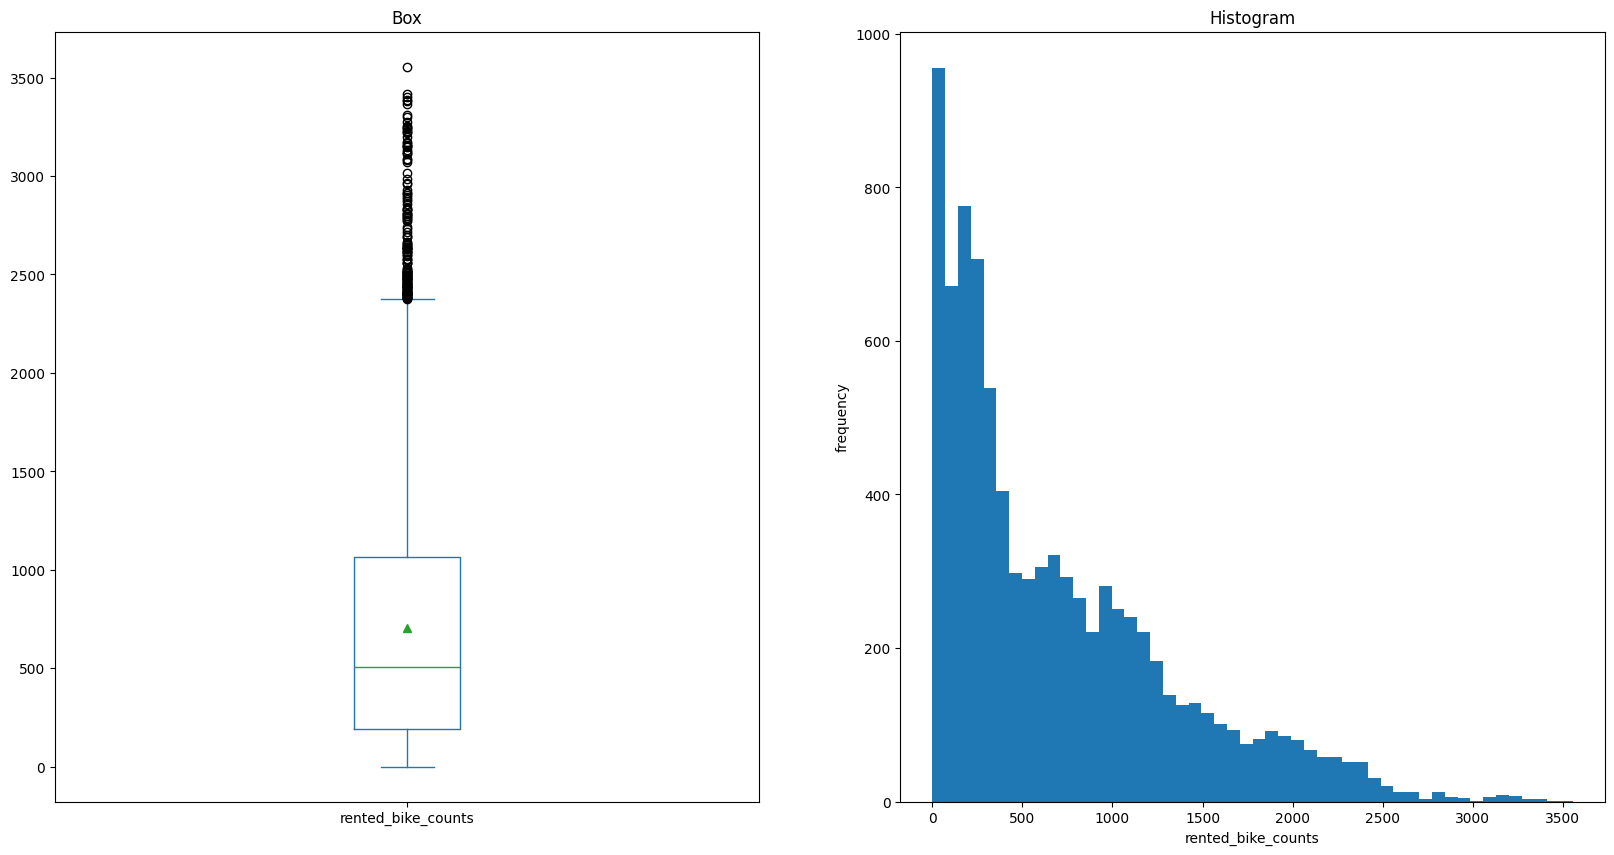

In [217]:
plot_box_and_hist(data, "rented_bike_counts", bins=50)

Dai grafici ottenuti per la variabile `rented_bike_counts`, vediamo che per la maggior parte delle ore prese in considerazione, ci sono relativamente pochi noleggi. Notiamo che la mediana è di circa 500 noleggi all'ora, e la media è leggermente più alta, a circa 700. Notiamo inoltre la presenza di molti outlier nella parte superiore. I grafici descrivono ciò che ci aspettiamo: molti noleggi in poche ore "centrali" (ad esempio orari di punta), e pochi noleggi nel resto della giornata. Bisogna considerare anche il fatto che le misure sono condotte anche nelle ore notturne, nelle quali ci aspettiamo molti meno noleggi.

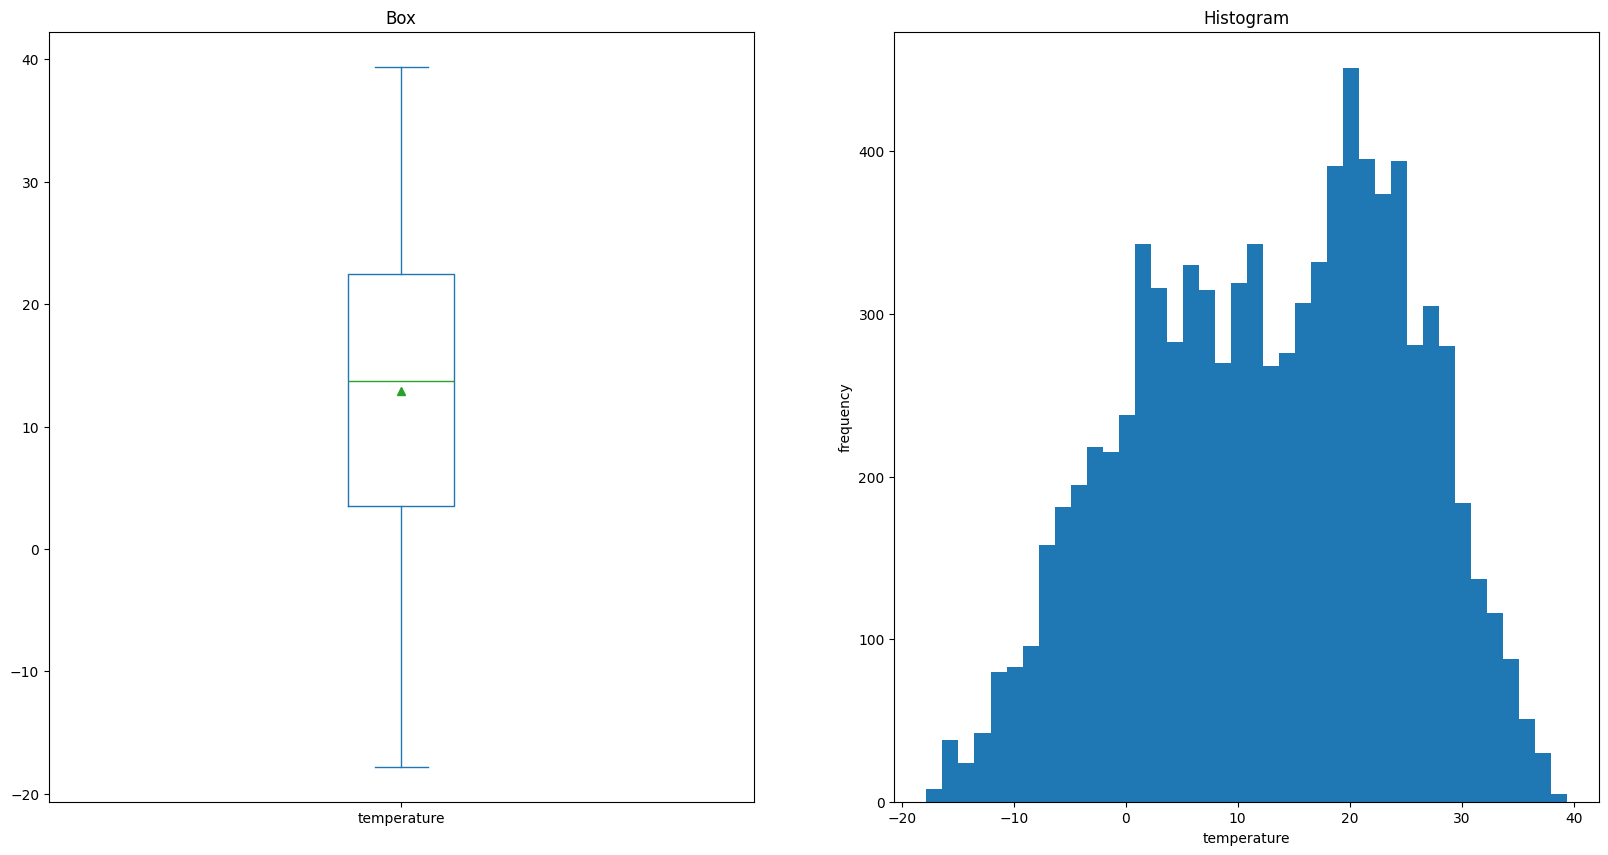

In [218]:
plot_box_and_hist(data, "temperature", bins=40)

Dai grafici della variabile `temperature` vediamo che l'istogramma segue approssimativamente una distribuzione normale, in linea con quello che ci aspettiamo. Le temperature registrate vanno da -18 a circa 40 gradi. L'escursione termica è molto alta (deviazione standard di quasi 12 gradi), infatti Seoul è considerata una città molto fredda e secca d'inverno, e calda e umida d'estate. Dal grafico a box notiamo che non sono presenti outliers, e che la mediana è in linea con la media.

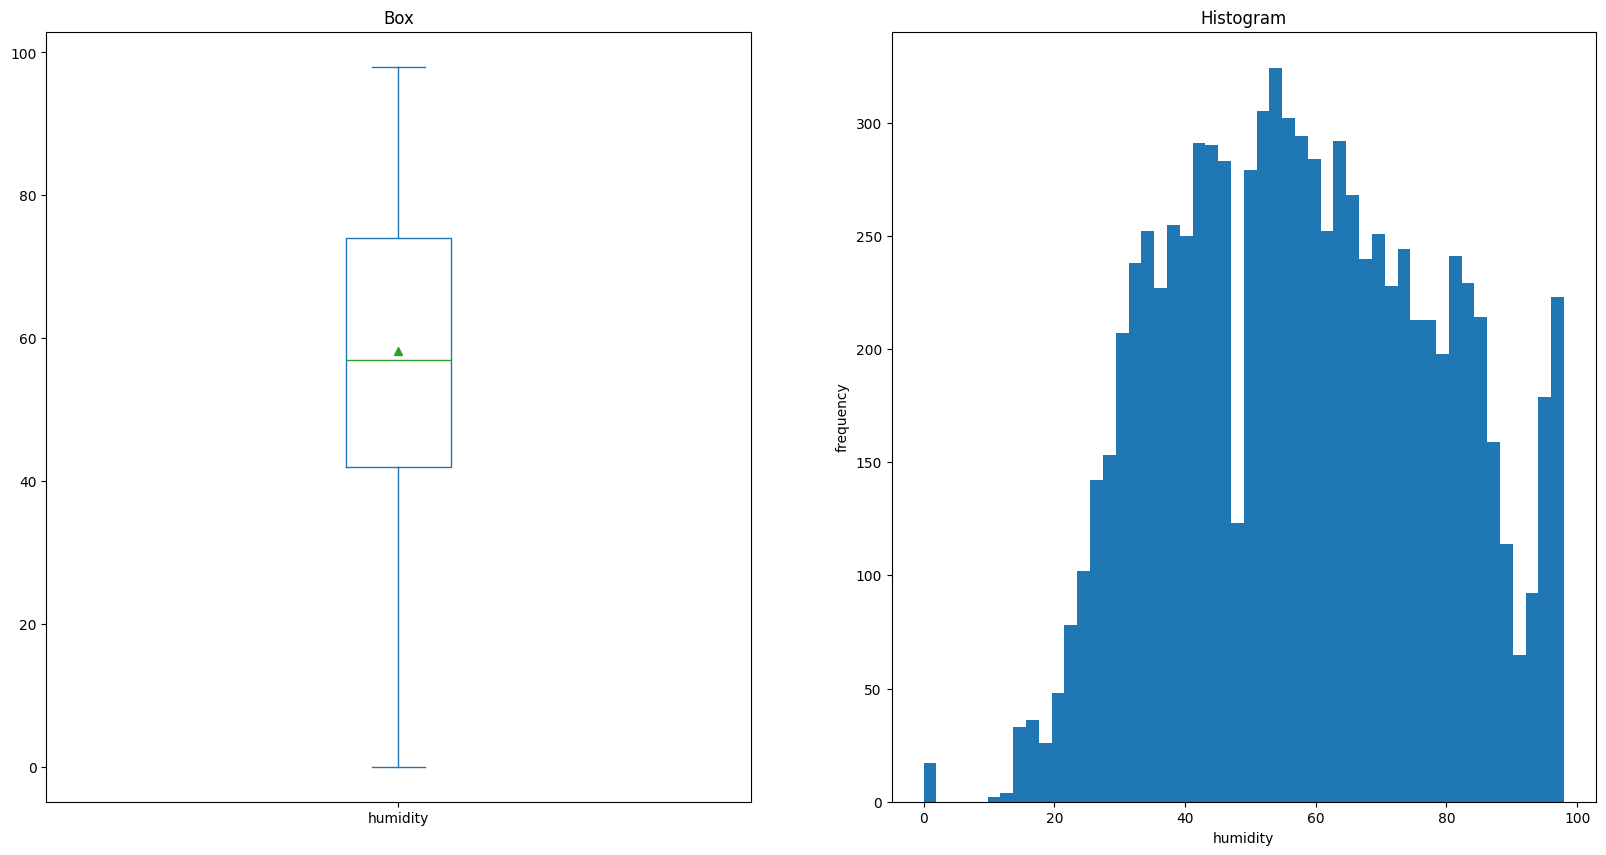

In [219]:
plot_box_and_hist(data, "humidity", bins=50)

Come per la temperature, dalla variabile `humidity` notiamo un andamento che ricorda vagamente una distribuzione normale. Come detto per la temperature, Seoul è una città secca d'inverno e umida d'estate, per questo ritroviamo un ampio spettro con tutti i valori possibili di umidità.

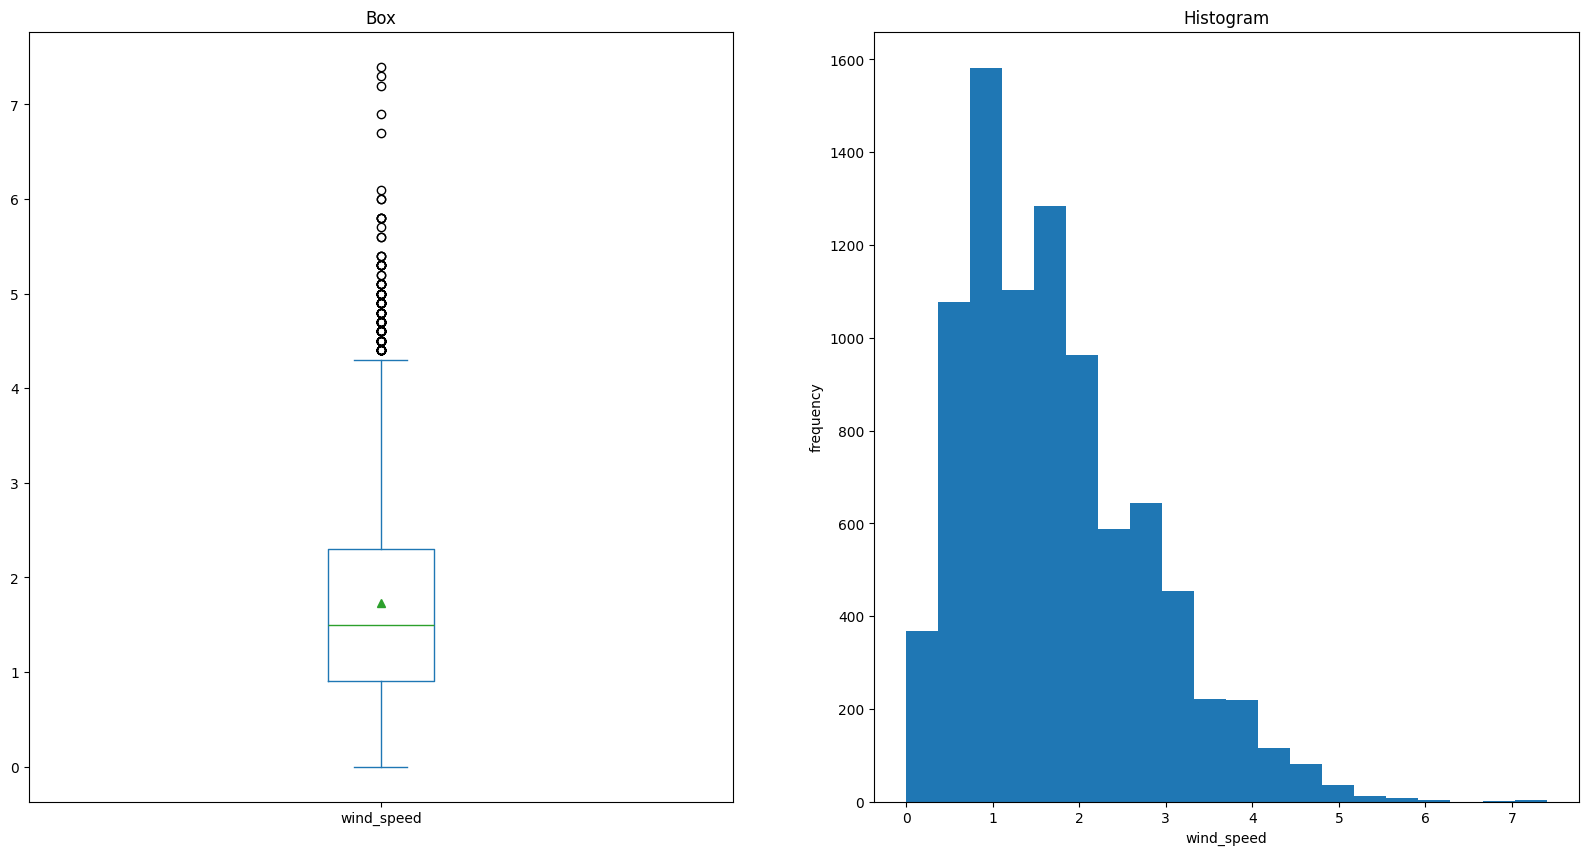

In [220]:
plot_box_and_hist(data, "wind_speed", bins=20)

I grafici della variabile `wind_speed` mostrano la presenza di poche ore con un vento relativamente forte (7.5 m/s, circa 27 km/h), e tante ore con un vento debole o assente. Questi valori sono in linea con i dati del vento nelle aree urbane, dove forti folate di vento sono molto rare.

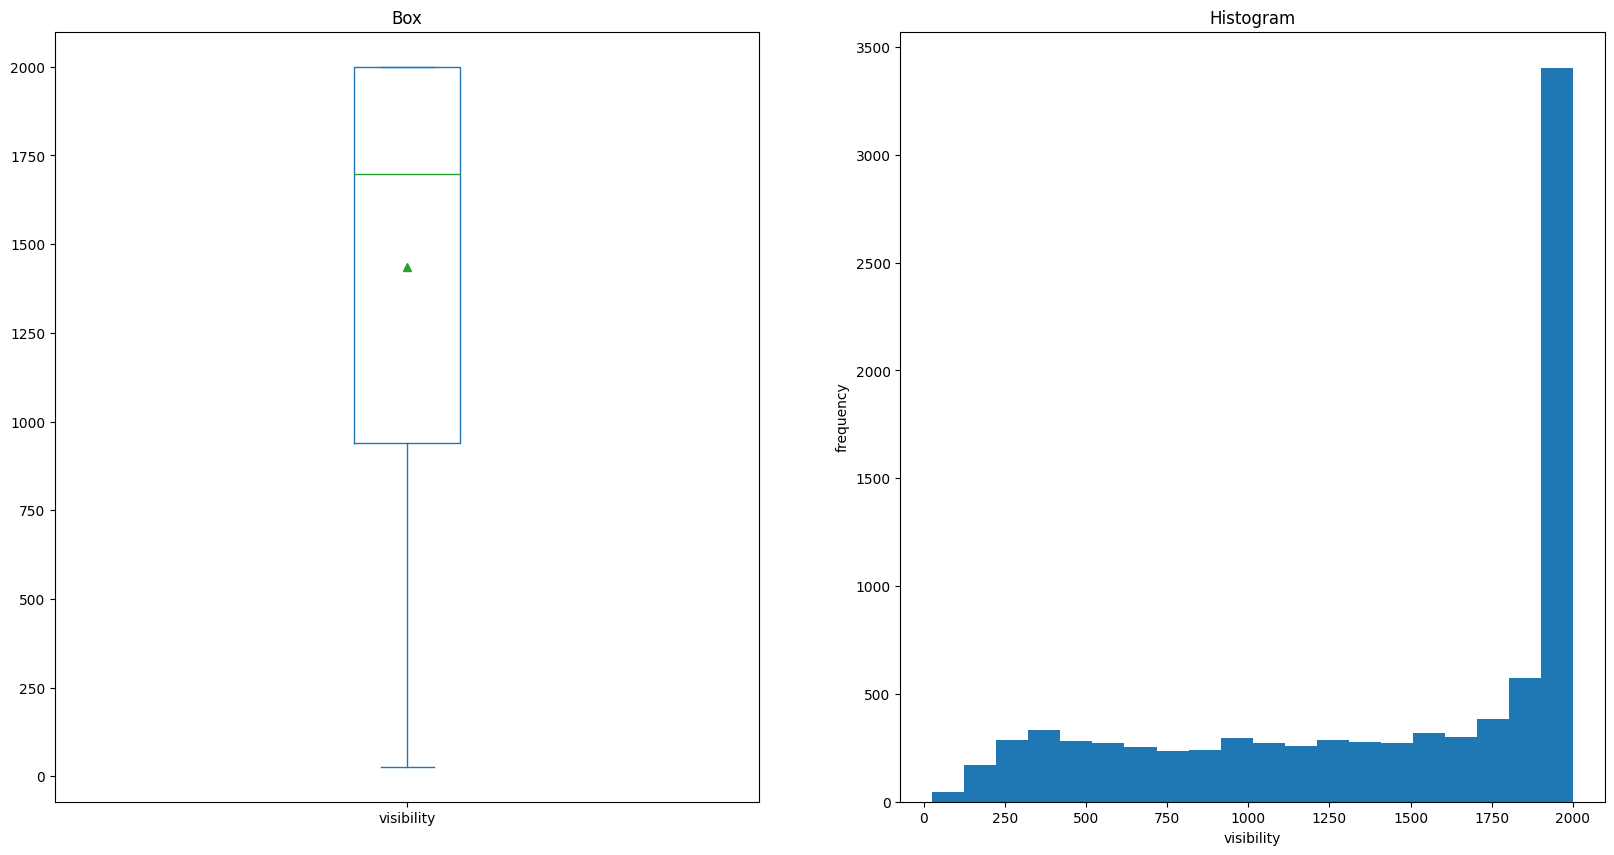

In [221]:
plot_box_and_hist(data, "visibility", bins=20)

I grafici della variabile `visibility` mostrano che la visibilità è per la maggior parte del tempo abbastanza buona (da 15 a 20km), anche se sembra che i valori siano limitati a 20km. È possibile quindi che i dati effettivi superino questo valore. La presenza di dati intermedi (da 1 a 15 km) è assolutamente plausibile, considerando che Seoul è una città con alto tasso di inquinamento, che ne limita la visibilità.

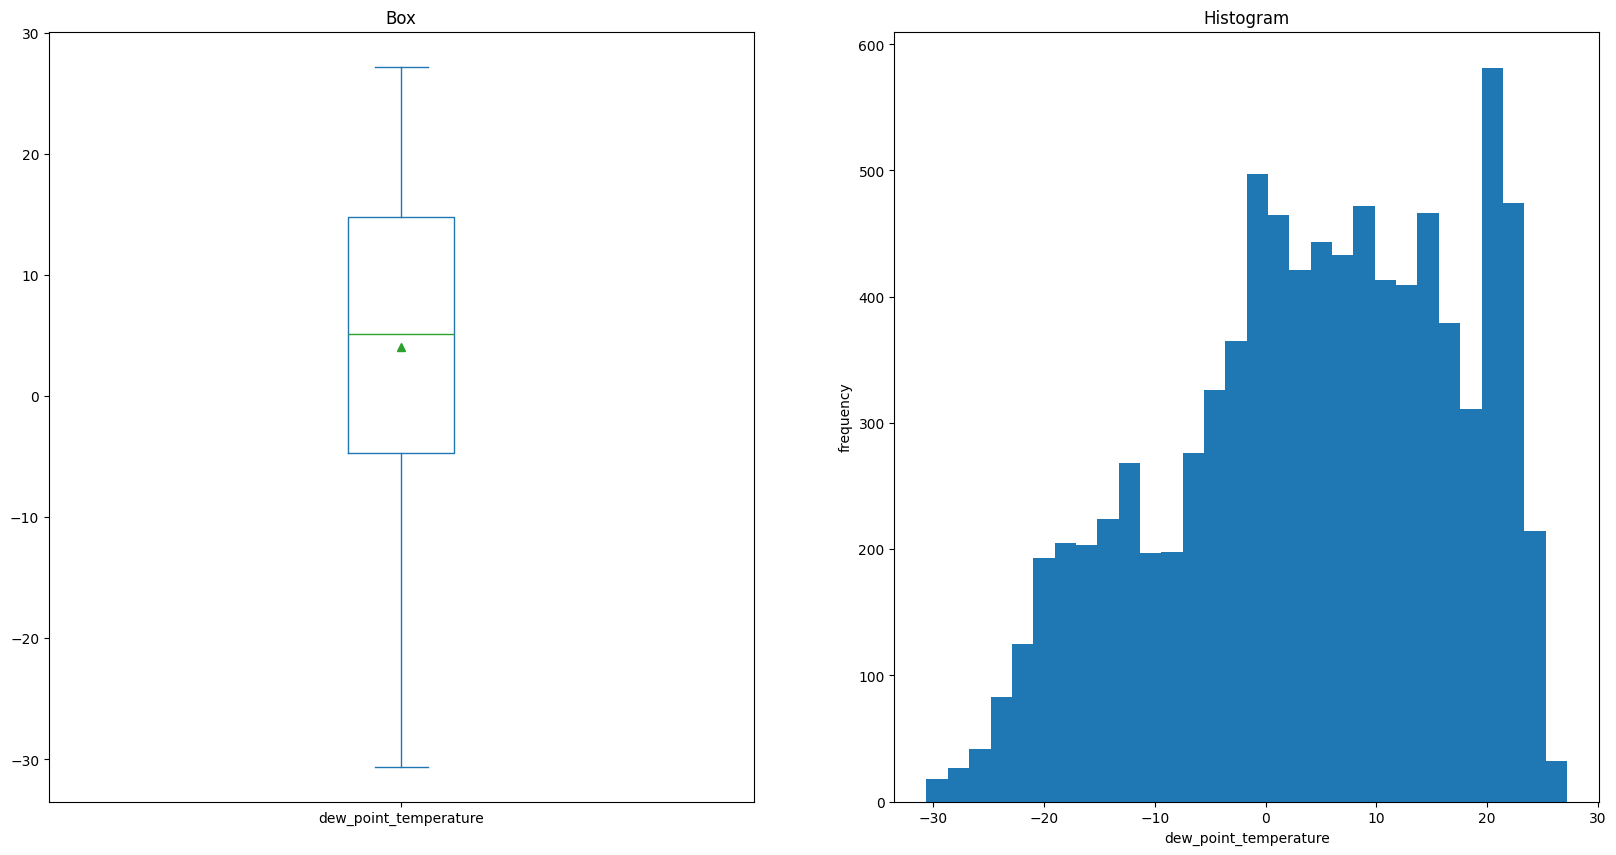

In [222]:
plot_box_and_hist(data, "dew_point_temperature", bins=30)

Anche questi grafici mostrano valori plausibili della temperatura di rugiada, con una distribuzione approssimativamente normale. Non sono presenti outliers.

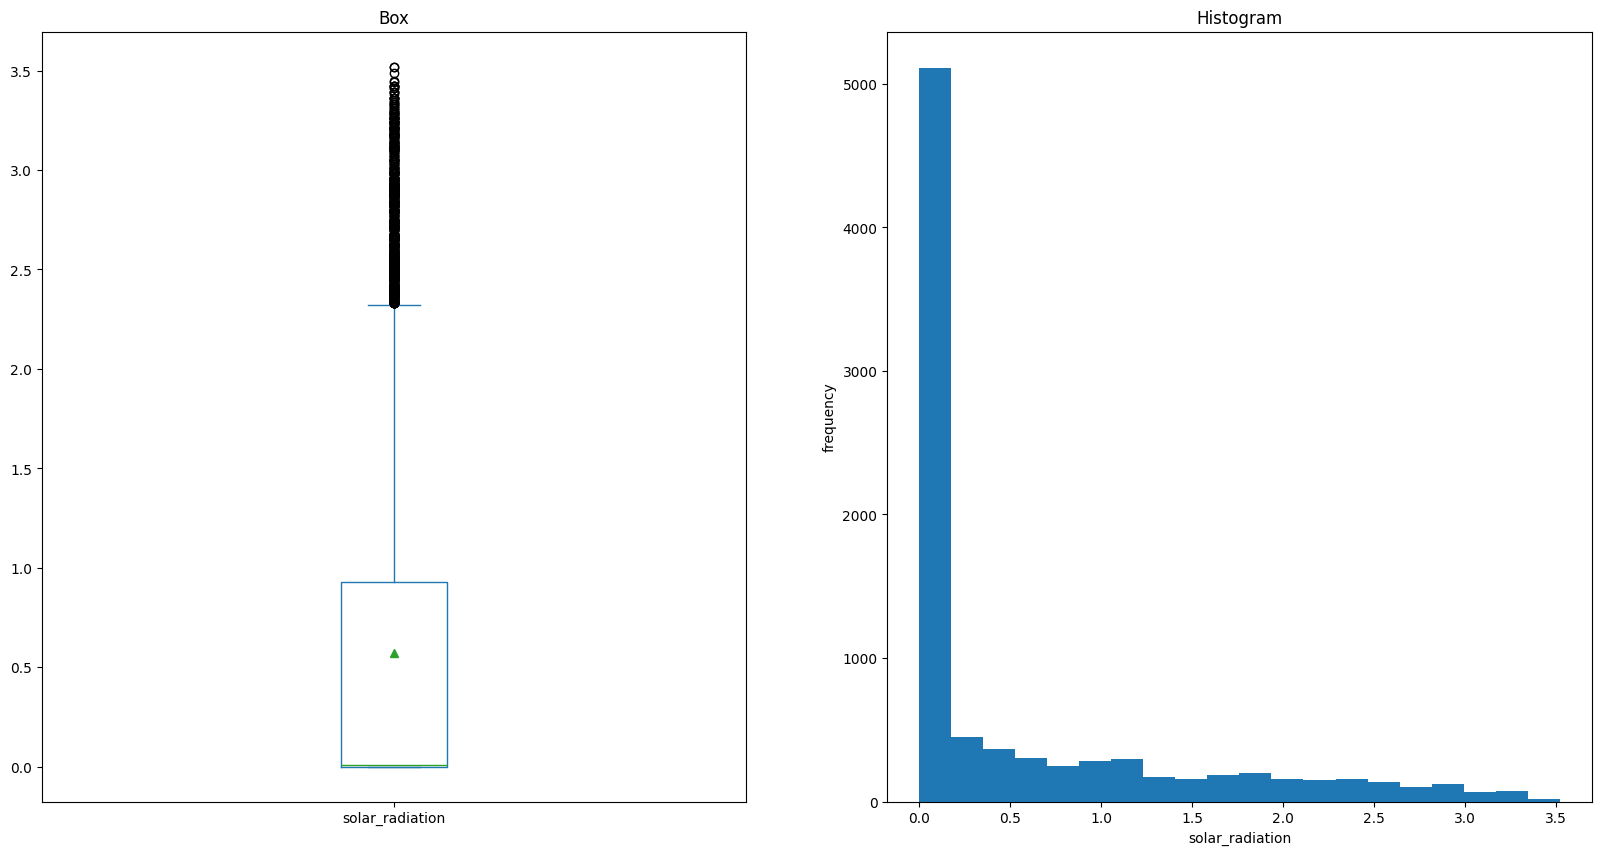

In [223]:
plot_box_and_hist(data, "solar_radiation", bins=20)

I grafici della variabile `solar_radiation` mostrano un comportamento atteso: molti valori dove la radiazione solare è nulla. Questi valori corrispondono con altissima probabilità alle ore notturne. Per questo motivo il grafico box mostra una mediana molto bassa (vicina allo 0) e moltissimi outlier.

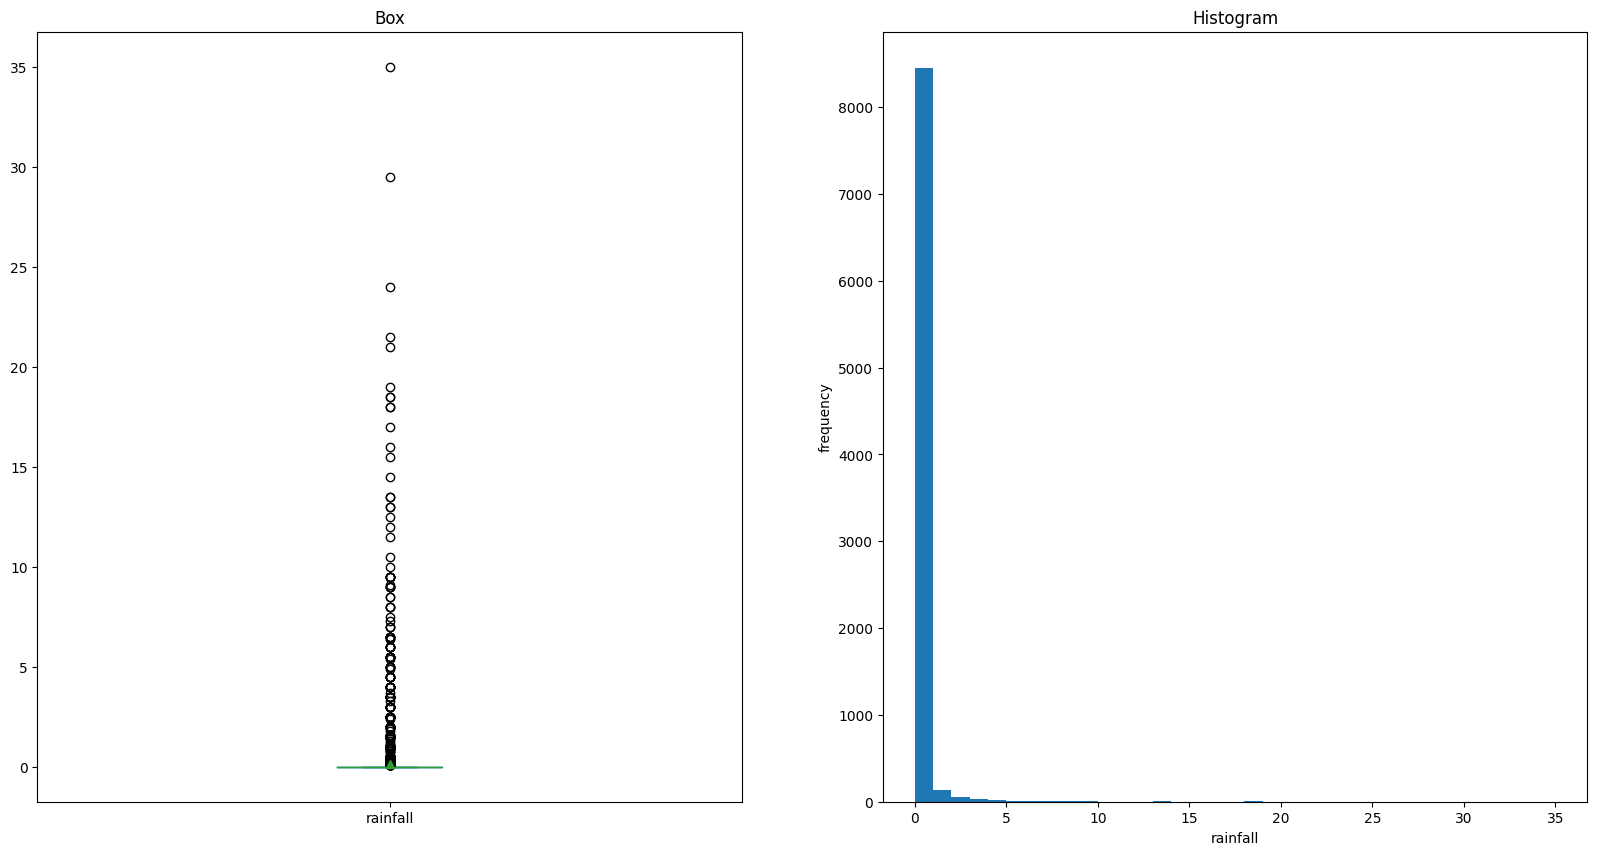

In [224]:
plot_box_and_hist(data, "rainfall", bins=35)

Dal grafico della variabile `rainfall` notiamo che per la maggior parte delle ore non si sono verificate piogge, ma sono presenti un numero limitato di ore dove le precipitazioni sono state intense. Per questo motivo, troviamo molti outlier nel grafico box.

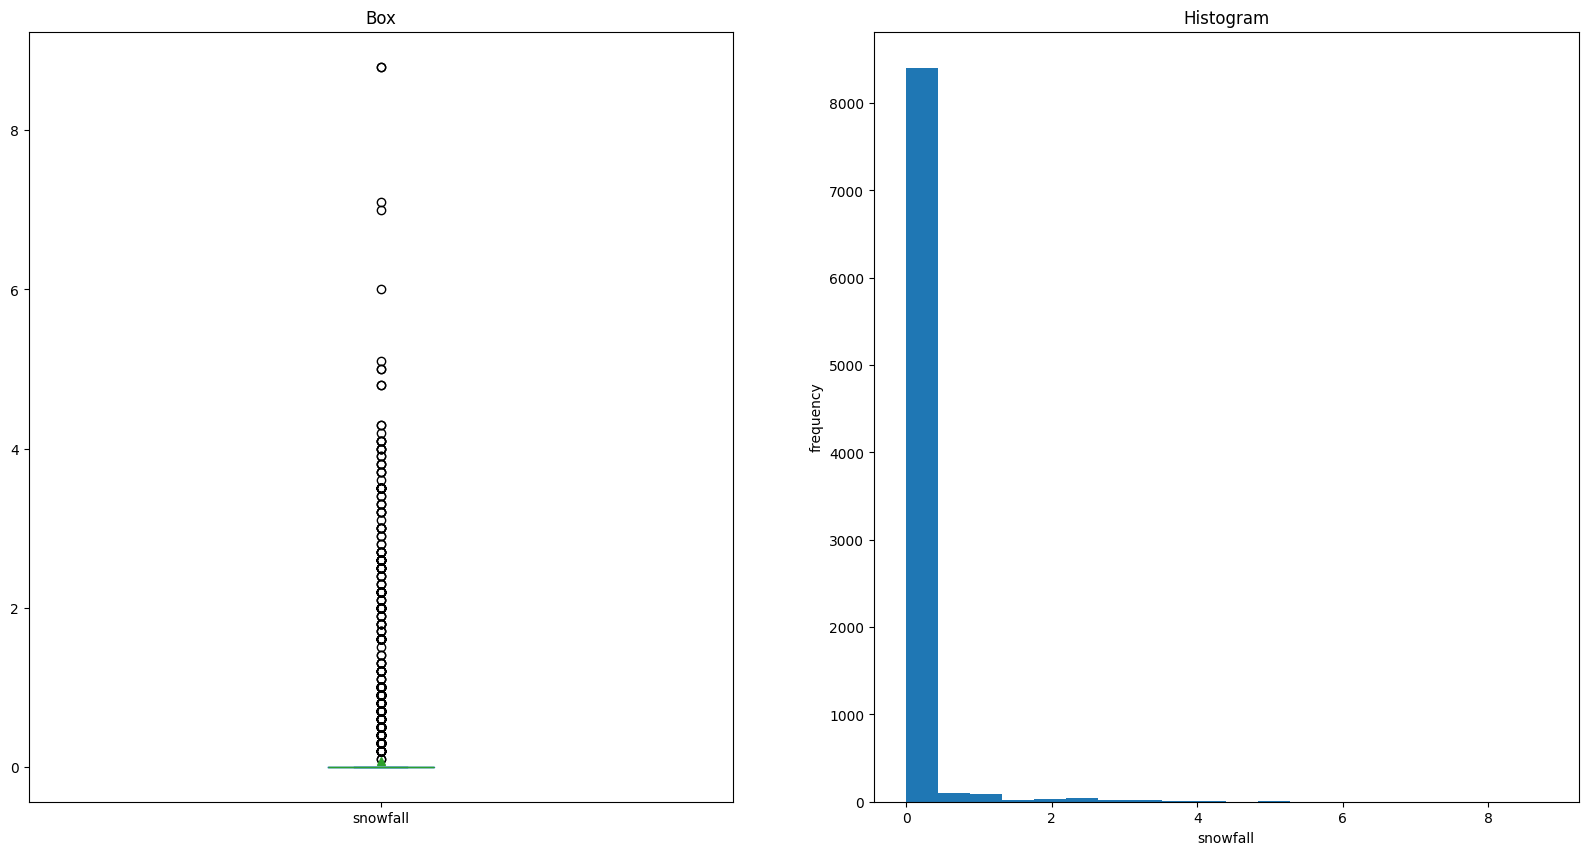

In [225]:
plot_box_and_hist(data, "snowfall", bins=20)

Lo stesso discorso può essere fatto per la variabile `snowfall`. Notiamo poche ore di precipitazioni nevose, e di conseguenza molti outlier.

Passiamo ora a mostrare informazioni per le variabili categoriche e binarie, attraverso grafici a torta.

In [226]:
def plot_pie(data, feature_name):
    data[feature_name].value_counts().plot.pie(autopct="%.2f%%", title=feature_name)

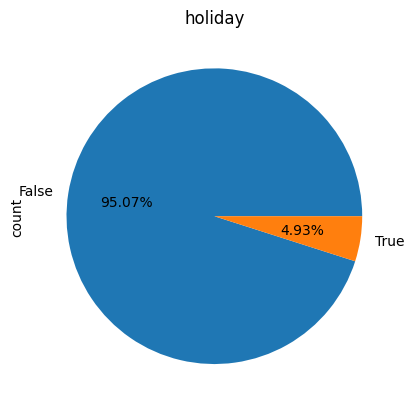

In [227]:
plot_pie(data, "holiday")

Dal grafico per la variabile `holiday` notiamo che la maggior parte delle ore prese in considerazione siano relative a giorni feriali, e solamente il 5% delle ore si riferiscano a giorni festivi. Sarà interessante vedere se nei giorni feriali il servizio di noleggio rimane disponibile, o viene interrotto.

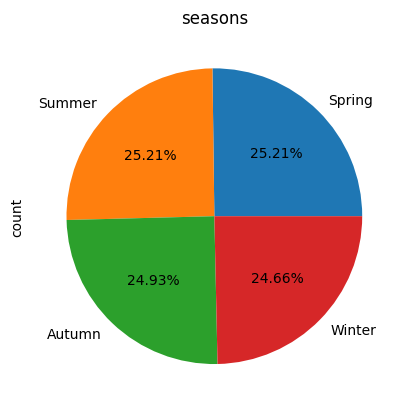

In [228]:
plot_pie(data, "seasons")

Come ci potevamo aspettare, dal grafico della variabile `seasons` vediamo che le ore sono distribuite uniformemente nelle 4 stagioni. Infatti il dataset copre un arco temporale di un anno esatto (8760 ore).

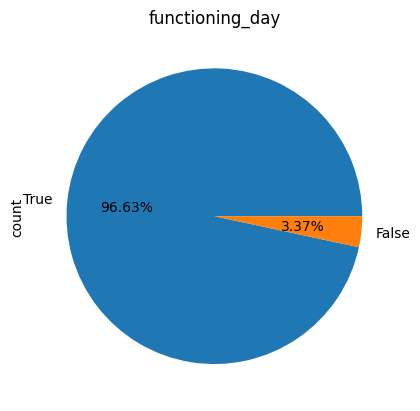

In [229]:
plot_pie(data, "functioning_day")

Dal grafico di `functioning_day` notiamo che solamente nel 3.37% delle ore annue il servizio non è in funzione. Ci aspettiamo che in queste ore il numero di noleggi sia 0.  Successivamente analizzeremo se queste ore coincidono con le ore di giornate festive.

#### Analisi esplorativa tra più features

Andiamo ora a cercare delle relazioni tra insiemi di features, e cerchiamo di estrapolare informazioni che potrebbero essere utili per la creazione del modello.

Verifichiamo che non ci siano noleggi effettuati nelle ore di non operatività del servizio:

In [230]:
data["functioning_day"].describe()

count     8760
unique       2
top       True
freq      8465
Name: functioning_day, dtype: object

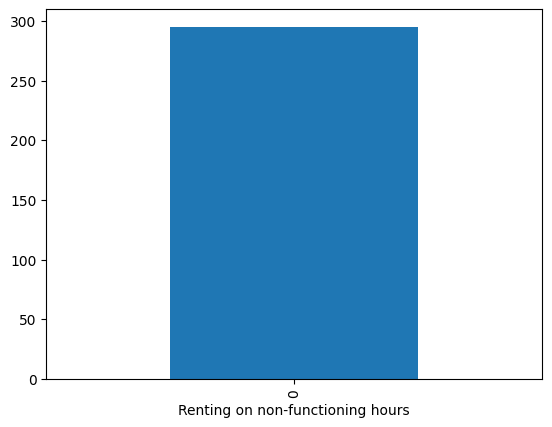

In [231]:
non_functioning_hours = (data["functioning_day"] == False)

data[non_functioning_hours]["rented_bike_counts"].value_counts().plot.bar(xlabel="Renting on non-functioning hours");

Vediamo dal grafico che descrive il numero di noleggi nei soli giorni di non operabilità che i noleggi sono 0. Questo significa che, come ci aspettavamo, non ci sono noleggi nelle ore di non funzionamento del servizio.

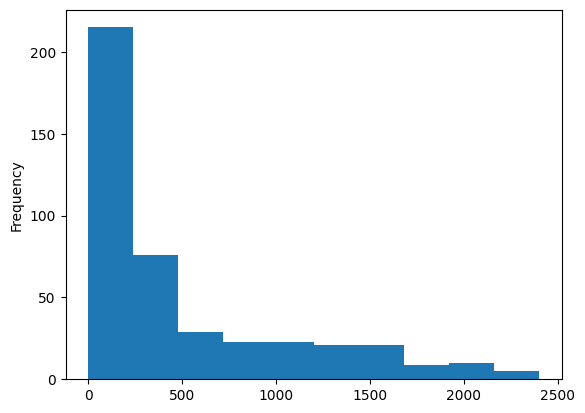

In [232]:
holiday_hours = (data["holiday"] == True)

data[holiday_hours]["rented_bike_counts"].plot.hist();

Vediamo che invece nei giorni festivi, ci sono comunque dei noleggi, che seguono approssimativamente l'andamento del grafico della variabile `rented_bike_counts` relativa a tutte le ore annuali. Questo significa che durante le ore dei giorni festivi ci sono approssimativamente tanti noleggi quanto nei giorni non festivi.

Verifichiamo se le ore festive coincidono, anche in parte, con le ore di non funzionamento del servizio:

In [233]:
holidays_and_no_functioning = (data["holiday"] == True) & (data["functioning_day"] == False)
print(f'Holiday and non functioning day hours: {data[holidays_and_no_functioning]["hour"].count()}')

Holiday and non functioning day hours: 24


I risultati mostrano che ci sono 24 ore annue di non funzionamento combinato con ore di festività, che rappresentano una piccolissima parte delle ore totali. Ovviamente, in queste ore i noleggi sono 0.

Verifichiamo ora che le radiazioni siano nulle nelle ore notturne, mostrando la radiazione solare media per ogni ora:

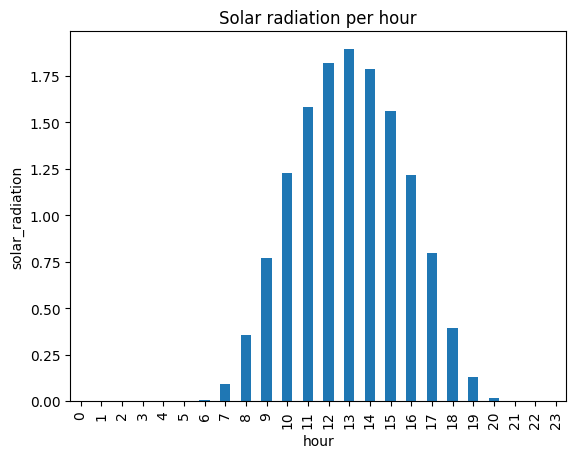

In [234]:
data.groupby('hour')["solar_radiation"].mean().plot.bar(title="Solar radiation per hour", ylabel="solar_radiation");

Come ci aspettavamo, la radiazione media nelle ore notturne è nulla, mentre cresce durante la giornata, arrivando a un amssimo nelle ore centrali, per poi scendere nuovamente.

Vediamo ora le ore in cui si sono verificati più noleggi:

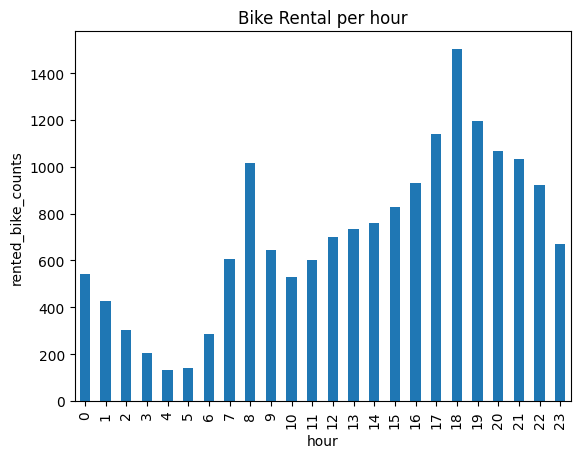

In [235]:
data.groupby("hour")["rented_bike_counts"].mean().plot.bar(title="Bike Rental per hour", ylabel="rented_bike_counts");

Notiamo che, come già ci aspettavamo, ci sono dei picchi nelle ore di punta lavorative (8 e 18), e che i noleggi calano notevolmente nelle ore notturne.

Vediamo il numero di noleggi quando le condizioni atmosferiche sono sfavorevoli. Troviamo la media dei noleggi quando non ci sono piogge, quando ci sono piogge, e quando ci sono piogge superiori alla media. Facciamo lo stesso con le precipitazioni nevose.

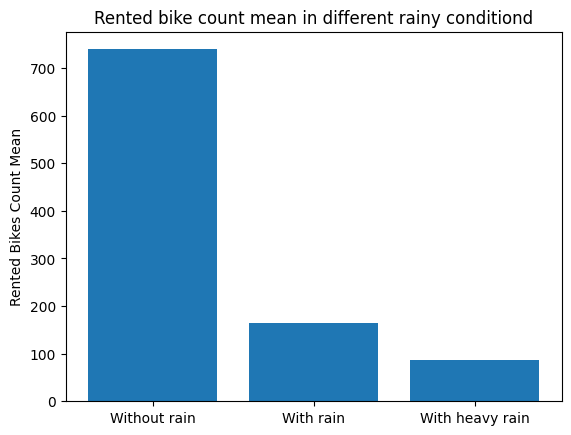

In [236]:
rent_mean_when_not_raining = data[data["rainfall"] == 0]["rented_bike_counts"].mean()

rent_mean_when_raining = data[data["rainfall"] > 0]["rented_bike_counts"].mean()


rainfall_mean_when_raining = data[data["rainfall"] > 0]["rainfall"].mean()
heavy_rainy_hours = data["rainfall"] > rainfall_mean_when_raining
rent_mean_when_heavy_raining = data[heavy_rainy_hours]["rented_bike_counts"].mean()

plt.bar(["Without rain", "With rain", "With heavy rain"], [rent_mean_when_not_raining,rent_mean_when_raining, rent_mean_when_heavy_raining])
plt.title("Rented bike count mean in different rainy conditiond")
plt.ylabel("Rented Bikes Count Mean")
plt.show()

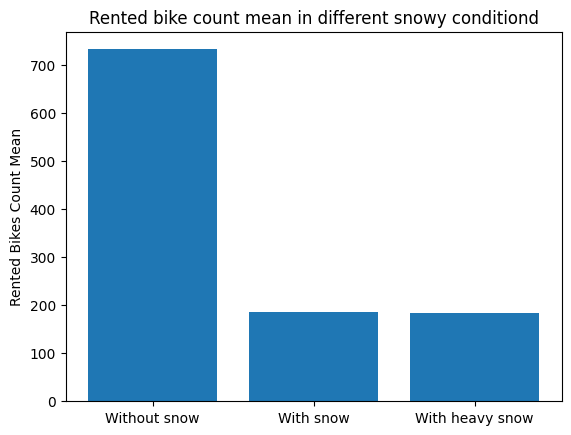

In [237]:
rent_mean_when_not_snowing = data[data["snowfall"] == 0]["rented_bike_counts"].mean()

rent_mean_when_snowing = data[data["snowfall"] > 0]["rented_bike_counts"].mean()


snowfall_mean_when_snowing = data[data["snowfall"] > 0]["snowfall"].mean()
heavy_snowy_hours = data["snowfall"] > snowfall_mean_when_snowing
rent_mean_when_heavy_snowing = data[heavy_snowy_hours]["rented_bike_counts"].mean()

plt.bar(["Without snow", "With snow", "With heavy snow"], [rent_mean_when_not_snowing,rent_mean_when_snowing, rent_mean_when_heavy_snowing])
plt.title("Rented bike count mean in different snowy conditiond")
plt.ylabel("Rented Bikes Count Mean")
plt.show()

Si nota chiaramente come il numero medio di noleggi cali drasticamente quando si verificano piogge, anche non intense, e nevicate. Questa informazione ci sarà utile nella fase di preparazione dei dati.

Vediamo le stagioni con più noleggi:

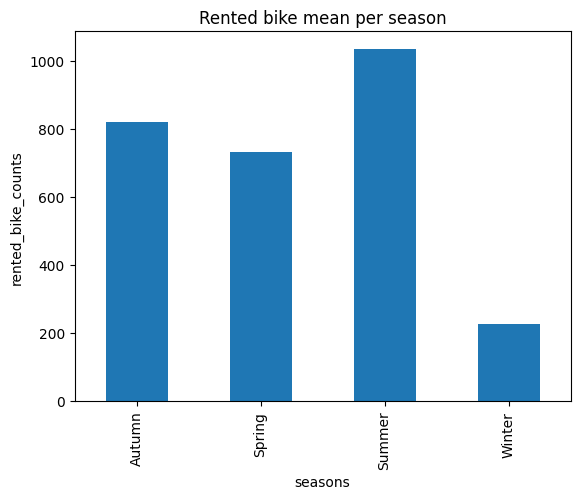

In [238]:
data.groupby("seasons", observed=True)["rented_bike_counts"].mean().plot.bar(title="Rented bike mean per season", ylabel="rented_bike_counts");

Come potevamo aspettarci, l'inverno è la stagione con meno noleggi, probabilemente a causa delle basse temperature e delle precipitazioni più frequenti. Invece la stagione con più noleggi è l'estate, quando le temperature sono più alte e il meteo è migliore.

Vediamo ora qualche grafico a dispersione per cercare relazioni tra le variabili:

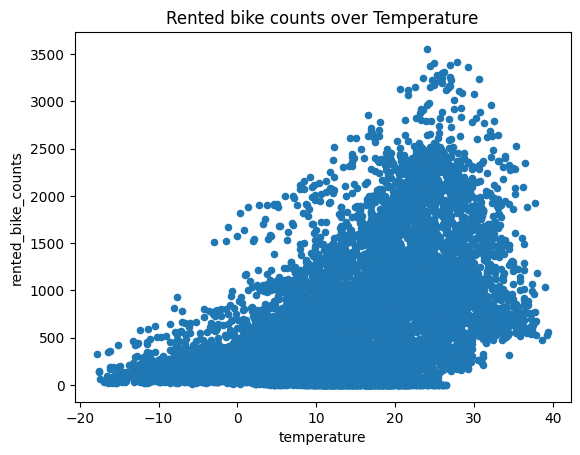

In [239]:
data.plot.scatter("temperature", "rented_bike_counts", title="Rented bike counts over Temperature");

Sembra esserci una relazione tra il numero di bici noleggiate e la temperatura registrata. Plausibilmente, quando le temperature sono più alte, ci sono più noleggi.

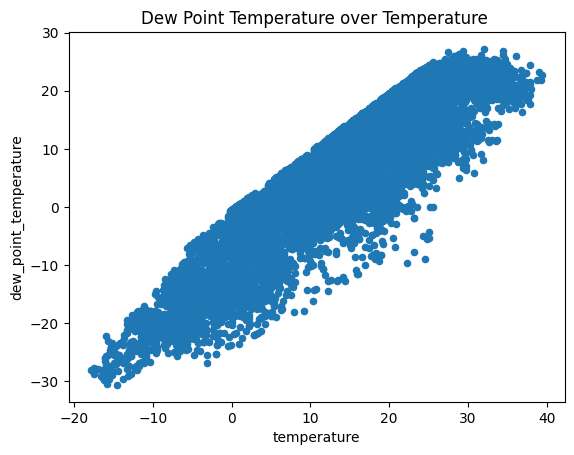

In [240]:
data.plot.scatter("temperature", "dew_point_temperature", title="Dew Point Temperature over Temperature ");

Sembra esserci una forte relazione tra la temperatura e la temperatura di rugiada. Infatti, la temperatura di rugiada (o punto di rugiada)  si può calcolare empiricamente a partire dalla temperatura ambientale e dall'umidità relativa.

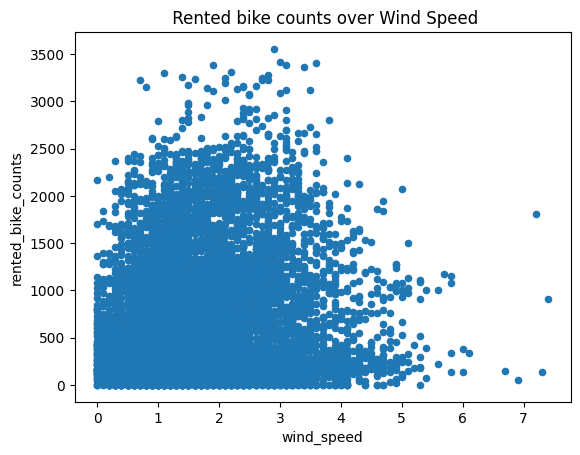

In [241]:
data.plot.scatter("wind_speed", "rented_bike_counts", title=" Rented bike counts over Wind Speed");

In questo caso non vediamo una forte relazione tra la la velocità del vento e il numero di biciclette noleggiate.

Passiamo ora a visualizzare una tabella completa con le correlazioni tra le variabili

[]

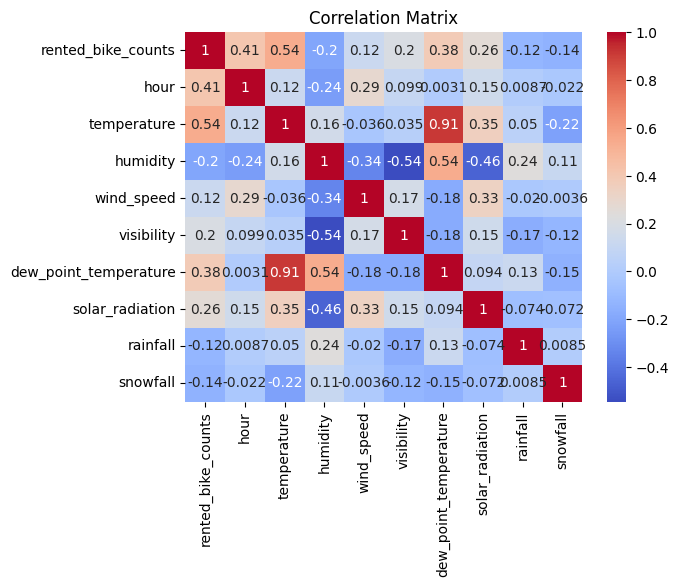

In [242]:
import seaborn as sns

corr_matr = data[["rented_bike_counts", "hour", "temperature", "humidity", "wind_speed", "visibility", "dew_point_temperature", "solar_radiation", "rainfall", "snowfall"]].corr()

sns.heatmap(corr_matr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.plot()

Dalla matrice di correlazione notiamo alcune relazioni già intuite precedentemente con i grafici. Vediamo che l'ora e il numero di noleggi sono molto correlate, così come la temperatura e il numero di noleggi.

Notiamo anche che la temperatura di rugiada è molto correlata con la temperatura. Potrebbe essere quindi utile nel modello eliminare una di queste due colonne, per evitare ridondanza dei dati.

## Preparazione dei dati e Preprocessing

In questa sezione prepariamo i dati per l'addestramento del modello e facciamo preprocessing.

### Preparazione dei dati e divisione del dataset

Iniziamo eliminando dal dataset le righe che riguardano ore dove il servizio non era disponibile. Infatti siamo sicuri che il conteggio dei noleggi sia 0 in questi casi.

In [243]:
data = data[data["functioning_day"]].drop("functioning_day", axis=1)

Abbiamo visto che le features `dew_point_temperature` e `temperature` hanno un indice di correlazione molto alto. Nei modelli di regressione lineare, è bene eliminare le variabili con alta correlazione, per eliminare ridondanza e ottenere migliore generalizzazione. Inoltre, si rende il modello anche più interpretabile. Per questo motivo, eliminiamo la colonna `dew_point_temperature`.

In [244]:
data = data.drop("dew_point_temperature", axis=1)

data.head()

,date,hour,rented_bike_counts,temperature,humidity,wind_speed,visibility,solar_radiation,rainfall,snowfall,seasons,holiday
0,2017-12-01,0,254,-5.2,37.0,2.2,2000,0.0,0.0,0.0,Winter,False
1,2017-12-01,1,204,-5.5,38.0,0.8,2000,0.0,0.0,0.0,Winter,False
2,2017-12-01,2,173,-6.0,39.0,1.0,2000,0.0,0.0,0.0,Winter,False
3,2017-12-01,3,107,-6.2,40.0,0.9,2000,0.0,0.0,0.0,Winter,False
4,2017-12-01,4,78,-6.0,36.0,2.3,2000,0.0,0.0,0.0,Winter,False


Dalla matrice di correlazione, si nota che non c'è una forte correlazione tra `rainfall` e `rented_bike_counts` e tra `snowfall` e `rented_bike_counts`. Inoltre le due variabili presentano molti outliers, che potrebbero ridurre le performance dei modelli.

Abbiamo visto durante l'analisi esplorativa che invece c'è un forte legame tra il numero di noleggi e condizioni atmosferiche sfavorevoli. Per questi motivi, creiamo delle nuove variabili booleane, che descrivono se in quella data ora si sono verificate piogge o nevicate.

In [245]:
rainy_hours = data["rainfall"] > 0
data.loc[rainy_hours, "rain"] = True
data.loc[~rainy_hours, "rain"] = False

data["rain"] = data["rain"].astype(bool)

In [246]:
snowy_hours = data["snowfall"] > 0
data.loc[snowy_hours, "snow"] = True
data.loc[~snowy_hours, "snow"] = False

data["snow"] = data["snow"].astype(bool)

Avremmo potuto anche inserire una nuova variabile che indica la presenza o meno di piogge intense (cioè maggiori del valore medio delle precipitazioni nei giorni piovosi). Tuttavia si è visto che ci sarebbe stato un forte sbilanciamento, infatti solo una piccola percentuale dei giorni dell'anno preso in considerazione presentavano piogge o nevicate intense.

Si è deciso anche di mantenere le features `rainfall` e `snowfall` per mantenere una certa granularità per quanto riguarda le precipitazioni. Sarà il modello che sceglierà se usare queste variabili e quanto peso darle.

In [247]:
data.head()

,date,hour,rented_bike_counts,temperature,humidity,wind_speed,visibility,solar_radiation,rainfall,snowfall,seasons,holiday,rain,snow
0,2017-12-01,0,254,-5.2,37.0,2.2,2000,0.0,0.0,0.0,Winter,False,False,False
1,2017-12-01,1,204,-5.5,38.0,0.8,2000,0.0,0.0,0.0,Winter,False,False,False
2,2017-12-01,2,173,-6.0,39.0,1.0,2000,0.0,0.0,0.0,Winter,False,False,False
3,2017-12-01,3,107,-6.2,40.0,0.9,2000,0.0,0.0,0.0,Winter,False,False,False
4,2017-12-01,4,78,-6.0,36.0,2.3,2000,0.0,0.0,0.0,Winter,False,False,False


Dividiamo ora le nostre istanze in set di addestramento e di validazione. Data l'importanza delle stagioni per la predizione (come emerso nell'analisi esplorativa), è fondamentale che questa divisione distribuisca i dati in modo uniforme sia per stagione che per mese.

Per garantire una distribuzione omogenea, useremo un rapporto di 0.2 per il set di validazione rispetto a quello di addestramento. In pratica, preleveremo a caso l'80% dei dati di ogni singolo mese per comporre il set di addestramento, e il restante 20% andrà a formare il set di validazione. Questo metodo assicura che entrambi i set contengano istanze rappresentative di ogni mese e, di conseguenza, di ogni stagione.

Questa tecnica è particolarmente utile quando il dataset copre un solo anno e le informazioni stagionali sono cruciali, come nel nostro caso. Se avessimo avuto a disposizione dati estesi su più anni, sarebbe stato più opportuno definire una "data limite" specifica per separare i set di addestramento e validazione.

In [248]:
# val_ratio = 0.2

# train_indices = []
# val_indices = []

# for month in data["date"].dt.month.unique():
#     data_month = data[data["date"].dt.month == month]
#     indices = data_month.index.tolist()
#     np.random.shuffle(indices)
#     n = len(data_month)
#     cut = int(n * (1 - val_ratio))
#     train_indices += data_month.index[:cut].tolist()
#     val_indices += data_month.index[cut:].tolist()

# train = data.loc[train_indices]
# validation = data.loc[val_indices]

Andiamo ad isolare la nostra variabile target, cioè `rented_bike_counts`.

In [249]:
# y_train = train["rented_bike_counts"]
# y_val = validation["rented_bike_counts"]

# X_train = train.drop("rented_bike_counts", axis=1).copy()
# X_val = validation.drop("rented_bike_counts", axis=1).copy()

Si è notato però, che utilizzare uno split come quello definito sopra porta a risultati relativamente più scarsi rispetto a un semplice split casuale (utilizzando `train_test_split`).  Si è notato una forte tendenza dei modelli all'overfitting, indicando una scarsa distribuzione dei dati tra addestramento e validazione. Questo può essere dovuto all'arco temporale troppo limitato del nostro dataset (solamente un anno). Con molta probabilità, se il dataset fosse stato rappresentativo di più anni (2+), il metodo sopra sarebbe risultato quello migliore per lo split. O ancora, se disponibili dati di molti anni (5+), sarebbe stato più conveniente dividere i dati in base al'anno (ad esempio: i primi 8 anni come train set e i restanti 2 anni come validation set).

Dopo queste considerazioni, ho deciso a scopo didattico di utilizzare la metodologia "meno corretta", ma che porta a risultati migliori. Il codice per ottenere uno split in base ai mesi è commentato nelle celle sopra.

Andiamo quindi a dividere il dataset in base a uno split casuale con l'apposita funzione di scikit-learn.

In [250]:
from sklearn.model_selection import train_test_split

y = data["rented_bike_counts"]
X = data.drop("rented_bike_counts", axis=1).copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Preprocessing dei dati

Suddividiamo le variabili in base al tipo di dato (numerico, binario, categorico).

In [251]:
numeric_vars = ["hour", "temperature", "humidity", "wind_speed", "visibility", "solar_radiation", "rainfall", "snowfall"]
binary_vars = ["holiday", "rain", "snow"]
categorical_vars = ["seasons"]

Passiamo ora a creare dei filtri per fare il preprocessing dei dati.

Abbiamo visto che nel nostro dataset sono presenti relazioni importanti legate alla data in cui è stata fatta la misurazione. Ad esempio potrebbe essere significativo il valore del giorno della settimana ai fini della predizione del numero di noleggi. Anche il mese potrebbe essere un indicatore importante, infatti abbiamo visto come le stagioni influenzino il numero di noleggi. Il mese potrebbe rappresentare un indicatore ancora più fine di questa caratteristica.

Definiamo una funzione che ottenga queste nuove variabili (giorno del mese, giorno della settimana e mese) a partire da una colonna generica di tipo `date`. Nel nostro dataset è fondamentale la ciclicità di queste informazioni, ad esempio è importante sapere che la data 31 dicembre è vicina alla data 1 gennaio. Per modellare efficacemente questo concetto di ciclicità, creiamo delle colonne seno e coseno per ogni features temporale.

In [252]:
def extract_date_fields(X):
    result = {}
    for col in X.columns:
        day = X[col].dt.day
        month = X[col].dt.month
        day_of_week = X[col].dt.dayofweek
        result[f"day_sine"]             = np.sin(2 * np.pi * day / 31)
        result[f"day_cosine"]           = np.cos(2 * np.pi * day / 31)
        result[f"month_sine"]           = np.sin(2 * np.pi * month / 12)
        result[f"month_cosine"]         = np.cos(2 * np.pi * month / 12)
        result[f"day_of_week_sine"]     = np.sin(2 * np.pi * day_of_week / 12)
        result[f"day_of_week_cosine"]   = np.cos(2 * np.pi * day_of_week / 12)
    return pd.DataFrame(result)

E creiamo un filtro per utilizzare questa funzione:

In [253]:
from sklearn.preprocessing import FunctionTransformer
date_transformer = FunctionTransformer(extract_date_fields)

Definiamo un filtro `ColumnTransformer`, che faccia la standardizzazione per le variabili numeriche e binarie, che faccia il One Hot Encoding per le variabili categoriche e che crei nuove variaibli per le informazioni temporali, utilizzando il filtro prima definito.

In [254]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), numeric_vars),
    ("binary", "passthrough", binary_vars),
    ("category", OneHotEncoder(), categorical_vars),
    ("date", date_transformer, ["date"]),
])

Per comodità, estraiamo già versioni preprocessate dei nostri set, per utilizzare modelli senza la pipeline.

In [255]:
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

Otteniamo i nomi delle variabili, che ci saranno utili per analizzare i modelli di regressione successivamente.

In [256]:
X_names = np.r_[
    numeric_vars,
    binary_vars,
    preprocessor.named_transformers_["category"].get_feature_names_out(categorical_vars),
    ["day_sine", "day_cosine", "month_sine", "month_cosine", "day_of_week_sine", "day_of_week_cosine"],
].tolist()

In [257]:
print("\n".join(X_names))

hour
temperature
humidity
wind_speed
visibility
solar_radiation
rainfall
snowfall
holiday
rain
snow
seasons_Autumn
seasons_Spring
seasons_Summer
seasons_Winter
day_sine
day_cosine
month_sine
month_cosine
day_of_week_sine
day_of_week_cosine


# Addestramento dei modelli

In questa sezione andremo ad addestrare e validare alcuni modelli per la regressione.

Definiamo una funzione per validare i modelli che andremo ad addestrare. Come metriche utilizziamo lo score $ R^2 $, il Mean Square Error (MSE) e il Mean Absolute Percentage Errore (MAPE).

In [258]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

def print_score(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    print(f'Mean Square Error:                  {mse:.5f}')
    print(f'R2 Score:                           {r2:.5}')
    print(f'Mean Absolute Percentage Error:     {mape:.5%}')

## Modelli di regressione lineare

Andiamo ad analizzare i modelli di regressione lineare.

Iniziamo con un semplice modello di regressione lineare.

In [259]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()

linear_regression.fit(X_train, y_train)

print_score(linear_regression, X_val, y_val)

Mean Square Error:                  162211.41102
R2 Score:                           0.58681
Mean Absolute Percentage Error:     152.80700%


Notiamo che gli errori MSE e MAPE sono molto alti, mentre lo score $ R^2 $ è mediamente elevato. Da queste informazioni riusciamo a capire che, seppur il modello non è del tutto inaffidabile, probabilmente le relazioni non riescono ad essere catturate correttamente tramite questo semplice modello lineare.

Mostriamo i parametri ottenuti con questo primo modello, e analiziamone i valori.

In [260]:
pd.Series(linear_regression.coef_, index=X_names).sort_values(ascending=False)

seasons_Autumn        333.976640
temperature           254.411417
hour                  209.912753
snow                  161.894230
day_of_week_sine       86.171282
day_of_week_cosine     34.086109
day_sine               33.650631
month_sine             19.807677
wind_speed             16.972239
snowfall               -5.176526
day_cosine            -15.494545
rainfall              -18.959586
visibility            -25.512850
solar_radiation       -71.783431
seasons_Winter        -72.142503
holiday              -112.455240
seasons_Spring       -125.300774
seasons_Summer       -136.533363
humidity             -160.550982
month_cosine         -319.927397
rain                 -502.806820
dtype: float64

Si nota che molta importanza è data alla temperatura, all'ora, alle diverse stagioni, alle precipitazioni e al mese, proprio come ci si aspettava.

Proviamo ora ad utilizzare delle feature polinomiali (di grado 2) con un modello Ridge, dove andiamo a specificare il parametro $ \alpha $.

In [261]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

ridge = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("linreg", Ridge(alpha=0.1)),
])

ridge.fit(X_train, y_train)

print_score(ridge, X_val, y_val)

Mean Square Error:                  101728.13886
R2 Score:                           0.74088
Mean Absolute Percentage Error:     92.79530%


Vediamo che utilizzando una regressione polinomiale di grado 2 gli errori calano, e lo score $R^2$ aumenta. Questo potrebbe farci intuire che modelli non lineari possano essere più efficaci a catturare le relazioni tra features.

Eseguiamo una Grid Search per ottenere gli iperparametri migliori a partire da una griglia che definiamo. Utilizziamo per validare i dati la Cross Validation K-Fold.

In [262]:
from sklearn.model_selection import KFold

kfold_5 = KFold(5, shuffle=True, random_state=42)

In [263]:
from sklearn.model_selection import GridSearchCV

Il grado del polinomio viene scelto tra 1, 2 e 3. L'iperparametro $\alpha$ invece viene scelto tra una gamma logaritmica che varia tra 0.001 e 1000.

In [264]:
ridge = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("linreg", Ridge()),
])

grid = {
    "poly__degree": [1, 2, 3],
    "linreg__alpha": np.logspace(-2, 3, 6),
}

gs_ridge = GridSearchCV(ridge, grid, cv=kfold_5)

gs_ridge.fit(X_train, y_train)
print_score(gs_ridge, X_val, y_val)


Mean Square Error:                  69561.90729
R2 Score:                           0.82281
Mean Absolute Percentage Error:     70.55243%


Vediamo che gli errori sono diminuiti ancora, e lo score aumentato. Andiamo a vedere gli iperparametri scelti dalla Grid Search:

In [ ]:
gs_ridge.best_params_

Il metodo di ricerca ha selezionato il polinomio di terzo grado e un valore di $\alpha$ pari a 1000. Di seguito sono elencate tutte le statistiche dei modelli migliori:

In [ ]:
pd.DataFrame(gs_ridge.cv_results_).sort_values("rank_test_score").head(5)

## Alberi di regressione

Passiamo ad analizzare il comportamento di un'altra famiglia di modelli per la regressione: gli alberi decisionali di regressione. Questi modelli sono in genere più efficaci e precisi dei modelli visti precedentemente, e riescono a rappresentare meglio le relazioni tra le variabili.

Iniziamo definendo un modello di tipo Decision Tree Regressor, andando a limitare la profondità massima a 10.

In [265]:
from sklearn.tree import DecisionTreeRegressor

regtree = DecisionTreeRegressor(
    max_depth=10,
    min_samples_leaf=1,
)

regtree.fit(X_train, y_train)

print_score(regtree, X_val, y_val)

Mean Square Error:                  57017.31517
R2 Score:                           0.85476
Mean Absolute Percentage Error:     44.42758%


Notiamo dai valori di errori e score $R^2$ che, come era atteso, il modello riesce a generalizzare molto meglio i dati di training, fornendo delle predizioni migliori rispetto ai modelli lineari.

Tracciamo il grafico che mostra alcuni nodi del modello, tramite l'apposita funzione:

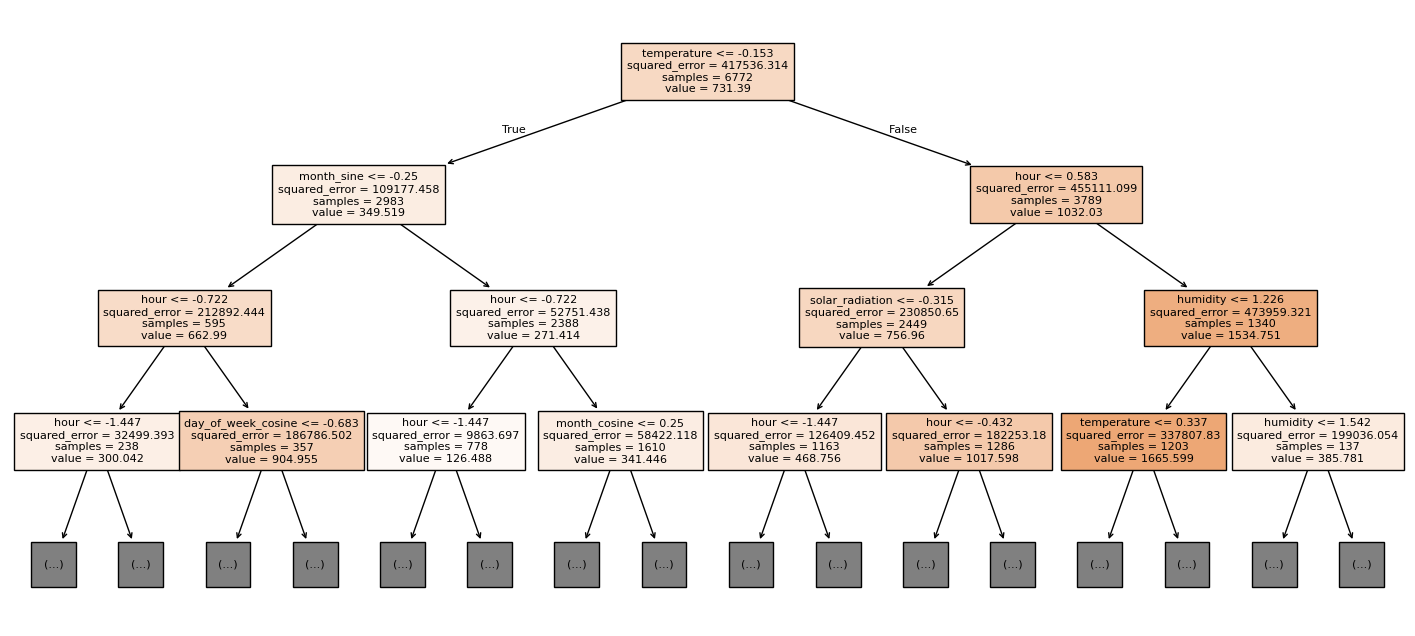

In [266]:
from sklearn.tree import plot_tree

plt.figure(figsize=(18, 8))
plot_tree(regtree, feature_names=X_names, max_depth=3, filled=True, fontsize=8);

E mostriamo l'importanza delle features ottenute dal modello ad albero.

In [267]:
pd.Series(regtree.feature_importances_, index=X_names).sort_values(ascending=False)

temperature           0.349782
hour                  0.324497
humidity              0.105444
solar_radiation       0.089785
day_of_week_cosine    0.041634
month_sine            0.032938
month_cosine          0.012753
rain                  0.012317
rainfall              0.010355
holiday               0.005747
day_sine              0.004659
day_cosine            0.003422
visibility            0.002632
wind_speed            0.001918
day_of_week_sine      0.001078
snowfall              0.000574
seasons_Summer        0.000308
seasons_Autumn        0.000088
seasons_Spring        0.000062
snow                  0.000008
seasons_Winter        0.000000
dtype: float64

Le features più importanti sono (in ordine): temperatura, ora del giorno, umidità, radiazione solare e giorno della settimana. Questo rappresenta ciò che ci aspettiamo dal modello, come già detto più volte. Più curiosa è la scelta della variabile di umidità, che probabilmente intensifica la temperatura percepita (più caldo d'estate e più freddo d'inverno), diventando un fattore decisivo per il noleggio di biciclette.

Ora passiamo ad addestrare e validare un modello di tipo Random Forest. Gli iperparametri che possiamo scegliere aumentano rispetto al semplice albero decisionale. Tra questi troviamo il numero massimo di campioni per ogni albero, il numero massimo di variabili per ogni albero e il numero di stimatori (alberi) da costruire. Usiamo dei valori definiti manualmente.

In [268]:
from sklearn.ensemble import RandomForestRegressor

rfm = RandomForestRegressor(max_samples=0.6, max_features="sqrt", n_estimators=1000, max_depth=None, n_jobs=-1)

rfm.fit(X_train, y_train)
print_score(rfm, X_val, y_val)

Mean Square Error:                  40996.56290
R2 Score:                           0.89557
Mean Absolute Percentage Error:     49.86094%


Il modello migliora ancora rispetto ai regressori lineari, e anche rispetto all'albero decisionale. È noto infatti che le Random Forest siano uno dei modelli più potenti per la regressione.

In [269]:
pd.Series(rfm.feature_importances_, index=X_names).sort_values(ascending=False)

hour                  0.245785
temperature           0.177683
humidity              0.082850
solar_radiation       0.081432
seasons_Winter        0.068933
month_cosine          0.068270
month_sine            0.039709
wind_speed            0.035024
visibility            0.034162
rain                  0.025121
rainfall              0.024195
day_sine              0.021369
day_of_week_cosine    0.020188
day_cosine            0.018211
seasons_Summer        0.017618
seasons_Autumn        0.013633
day_of_week_sine      0.011632
seasons_Spring        0.007277
snowfall              0.002492
holiday               0.002380
snow                  0.002033
dtype: float64

Le feature più importanti trovate da questo modello sono molto simili a quelle dell'albero decisionale, con la differenza che qua viene data più importanza alla stagione invernale. Inoltre, le importanze delle variabili sembrano distribuite più uniformemente.

Passiamo a trovare dei valori ottimali degli iperparametri per questo modello. In particolare, vogliamo massimizzare le performance del modello in base al numero massimo di campioni per stimatore, alla profondità massima e al numero massimo di feature per stimatore. Utilizziamo una Grid Search per trovare questi valori ottimali.

In [270]:
grid = {
    "max_samples": [0.2, 0.4, 0.6, 0.8],
    "max_depth": [None, 4, 8, 16],
    "max_features": ["sqrt", "log2", None, 0.5],
}

rfm = RandomForestRegressor(n_estimators=1000, n_jobs=-1)

gs_rfm = GridSearchCV(rfm, grid, cv=kfold_5)

gs_rfm.fit(X_train, y_train)

print_score(gs_rfm, X_val, y_val)

Mean Square Error:                  29158.02666
R2 Score:                           0.92573
Mean Absolute Percentage Error:     39.76726%


Il modello ottimale trovato presenta ancora una volta dei valori minori degli errori (MSE e MAPE) e uno score $R^2$ maggiore.

In [271]:
gs_rfm.best_params_

{'max_depth': None, 'max_features': None, 'max_samples': 0.8}

Il modello ottimale non considera limiti per la profondità masssima, utilizza tutte le variabili per ogni stimatore e il numero massimo di campioni per stimatore è l'80% dei campioni totali. Purchè questi valori degli iperparametri siano più propensi all'overfitting, sembra che con un numero relativamente limitato di dati di training nel nostro dataset, questo non avvenga, e anzi le capacità predittive del modello aumentano.

Di seguito sono elencati gli iperparametri ottimali per i 5 migliori modelli ottenuti.

In [272]:
pd.set_option('display.max_colwidth', None)  # To avoid string trunc

pd.DataFrame(gs_rfm.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_samples,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,11.313563,0.572301,0.188717,0.040464,None,None,0.8,"{'max_depth': None, 'max_features': None, 'max_samples': 0.8}",0.930574,0.927586,0.934764,0.934339,0.942227,0.933898,0.004923,1
59,9.522901,0.512243,0.198058,0.042972,16,None,0.8,"{'max_depth': 16, 'max_features': None, 'max_samples': 0.8}",0.929079,0.926649,0.934885,0.933482,0.941608,0.933141,0.005167,2
10,8.331592,0.960174,0.170692,0.027594,None,None,0.6,"{'max_depth': None, 'max_features': None, 'max_samples': 0.6}",0.926511,0.923702,0.930604,0.931774,0.937837,0.930086,0.004832,3
58,8.410795,1.043674,0.224254,0.059403,16,None,0.6,"{'max_depth': 16, 'max_features': None, 'max_samples': 0.6}",0.925511,0.921715,0.929732,0.930713,0.937355,0.929005,0.005263,4
15,5.441200,0.689234,0.195700,0.050001,None,0.5,0.8,"{'max_depth': None, 'max_features': 0.5, 'max_samples': 0.8}",0.923847,0.921642,0.928279,0.929161,0.934766,0.927539,0.004557,5


Passiamo ad analizzare le performance del modello Extreme Gradient Boost, ottenuto dalla libreria xgboost. Questo modello, a differenza degli altri modelli ad albero, esegue un training additivo di modelli. Viene creata una sequenza di modelli posizionati in serie, dove ogni modello "corregge" la predizione del suo precedente.

In [273]:
from xgboost import XGBRegressor

xgbm = XGBRegressor(objective='reg:squarederror', n_estimators=1000, verbosity=2)
xgbm.fit(X_train, y_train)

print_score(xgbm, X_val, y_val)

[18:42:21] INFO: /Users/runner/work/xgboost/xgboost/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (6772, 21, 142212).
Mean Square Error:                  24875.74805
R2 Score:                           0.93664
Mean Absolute Percentage Error:     34.70214%


L'addestramento è relativamente veloce, e i risultati sono i migliori ottenuti finora. Lo score $R^2$ è sopra al 0.90 e l'errore relativo è del 35%, mostrando le forti capacità predittive di questo tipo di modello.

In [274]:
pd.Series(xgbm.feature_importances_, index=X_names).sort_values(ascending=False)

rainfall              0.222670
seasons_Autumn        0.161331
holiday               0.102763
hour                  0.093630
temperature           0.092633
day_of_week_cosine    0.067028
seasons_Winter        0.060007
solar_radiation       0.050247
seasons_Spring        0.044590
humidity              0.032754
month_cosine          0.026770
month_sine            0.016032
seasons_Summer        0.006869
day_of_week_sine      0.005209
day_cosine            0.005050
day_sine              0.005047
snowfall              0.002955
wind_speed            0.002265
visibility            0.002149
rain                  0.000000
snow                  0.000000
dtype: float32

Vediamo che la feature più importante selezionata dal modello è la quantità di pioggia. Nessun altro modello ad albero ne aveva dato molta priorità, probabilmente per la poca presenza di ore piovose nel dataset. Questo modello invece sembra riuscito a trovare una correlazione forte, nonostante la variabile sia poco rappresentata. Il risultato è assolutamente plausibile, infatti, come già avevamo notato dai grafici e da quello che possiamo supporre, durante le ore di pioggia le persone sono meno incentivate ad utilizzare la bicicletta.

## Reti neurali

Costruiamo una semplice rete neurale, per cercare relazioni non lineari tra le features e la variabile obiettivo.

Usando il modello della libreria scikit-learn, definiamo una piccola rete neurale con 2 strati nascosti con rispettivamente 32 e 16 neuroni. Impostiamo un numero massimo di iterazioni a 500, un batch di dimensione 100 e utilizziamo la funzione di attivazione ReLU.

In [275]:
from sklearn.neural_network import MLPRegressor
from joblib import parallel_backend

with parallel_backend('threading', n_jobs=-1):
    mlp = MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=500, batch_size=100, activation="relu")

mlp.fit(X_train, y_train)

print_score(mlp, X_val, y_val)

Mean Square Error:                  68769.30288
R2 Score:                           0.82483
Mean Absolute Percentage Error:     68.58276%


/Users/matteobagnolini/Desktop/bike-renting-prediction/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


I risultati sono buoni, in genere migliori dei modelli lineari, ma peggiori dei modelli ad albero. Proviamo a fare una Grid Search per trovare gli iperparametri migliori.

In [276]:
grid = {
    "hidden_layer_sizes": [(32), (32, 8), (64, 32, 8)],
    "max_iter": [200, 500],
    "batch_size": [100, 300, None],
    "activation": ["relu", "tanh"],
}

model = MLPRegressor()

gs_mlp = GridSearchCV(model, grid, cv=kfold_5)

gs_mlp.fit(X_train, y_train)

/Users/matteobagnolini/Desktop/bike-renting-prediction/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matteobagnolini/Desktop/bike-renting-prediction/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matteobagnolini/Desktop/bike-renting-prediction/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matteobagnolini/Desktop/bike-renting-prediction/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning:

,estimator,MLPRegressor()
,param_grid,"{'activation': ['relu', 'tanh'], 'batch_size': [100, 300, ...], 'hidden_layer_sizes': [32, (32, ...), ...], 'max_iter': [200, 500]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_error'


In [277]:
print_score(gs_mlp, X_val, y_val)

Mean Square Error:                  39579.01797
R2 Score:                           0.89918
Mean Absolute Percentage Error:     45.79496%


I risultati sono molto buoni. Andiamo a vedere gli iperparametri selezionati dalla ricerca:

In [278]:
gs_mlp.best_params_

{'activation': 'relu',
 'batch_size': 100,
 'hidden_layer_sizes': (64, 32, 8),
 'max_iter': 500}

In [279]:
pd.set_option('display.max_colwidth', None)  # To avoid string trunc

pd.DataFrame(gs_mlp.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_batch_size,param_hidden_layer_sizes,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,15.797039,0.517530,0.004437,0.006229,relu,100,"(64, 32, 8)",500,"{'activation': 'relu', 'batch_size': 100, 'hidden_layer_sizes': (64, 32, 8), 'max_iter': 500}",0.889091,0.900018,0.904850,0.903503,0.915293,0.902551,0.008439,1
11,7.148270,0.098454,0.001357,0.000054,relu,300,"(64, 32, 8)",500,"{'activation': 'relu', 'batch_size': 300, 'hidden_layer_sizes': (64, 32, 8), 'max_iter': 500}",0.858998,0.846439,0.847358,0.854347,0.842368,0.849902,0.005962,2
4,6.167411,0.256098,0.005879,0.004561,relu,100,"(64, 32, 8)",200,"{'activation': 'relu', 'batch_size': 100, 'hidden_layer_sizes': (64, 32, 8), 'max_iter': 200}",0.813555,0.836272,0.815919,0.813703,0.877667,0.831423,0.024640,3
3,8.775826,0.364633,0.001288,0.000152,relu,100,"(32, 8)",500,"{'activation': 'relu', 'batch_size': 100, 'hidden_layer_sizes': (32, 8), 'max_iter': 500}",0.786734,0.761584,0.745734,0.796616,0.750558,0.768245,0.020053,4
10,2.829908,0.063923,0.002034,0.001217,relu,300,"(64, 32, 8)",200,"{'activation': 'relu', 'batch_size': 300, 'hidden_layer_sizes': (64, 32, 8), 'max_iter': 200}",0.747630,0.767557,0.736521,0.731778,0.754353,0.747568,0.012782,5


Notiamo subito che un modello che esegue per tante iterazioni e con tanti neuroni e tanti strati nascosti è più performante. Questo potrebbe essere un segnale che l'utilizzo di una rete neurale profonda potrebbe essere utile ai fini della predizione. Tuttavia, scikit-learn non è adatta a costruire reti profonde, e questo va oltre allo scopo del progetto. In futuro, sarebbe interessante costruire un modello di deep learning utilizzando framework come Pytorch o TensorFlow, e confrontarli con i "semplici" modelli di machine learning visti fino ad ora.

## Confronto tra modelli

Confrontiamo i risultati ottenuti tra i vari modelli, servendoci di una tabella

Definiamo una funzione per mostrare in una tabella i risultati complessivi.

In [280]:
def plot_table(models, X, y, sort_by="R2 Score", ascending=False):
    results = []
    for model_name, model in models.items():
        y_pred = model.predict(X)
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        mape = mean_absolute_percentage_error(y, y_pred)
        results.append({
            "Model": model_name,
            "MSE": round(mse, 3),
            "MAPE": round(mape, 5),
            "R2 Score": round(r2, 5),
        })
    
    df = pd.DataFrame(results).set_index("Model")
    return df.sort_values(sort_by, ascending=ascending)

Definiamo un dizionario dove associamo ad ogni nome il rispettivo modello:

In [283]:
models = {
    "Linear Regression": linear_regression,
    "Ridge Regression": gs_ridge,
    "Decision Tree": regtree,
    "Random Forest": gs_rfm,
    "XGBoost": xgbm,
    "MLP": gs_mlp,
}

In [284]:
plot_table(models, X_val, y_val, sort_by="R2 Score")

,MSE,MAPE,R2 Score
Model,,,
XGBoost,24875.748,0.34702,0.93664
Random Forest,29158.027,0.39767,0.92573
MLP,39579.018,0.45795,0.89918
Decision Tree,57017.315,0.44428,0.85476
Ridge Regression,69561.907,0.70552,0.82281
Linear Regression,162211.411,1.52807,0.58681


Verifichiamo che i modelli migliori sono rispettivamente XGBoost, Random Forest e MLP. Come abbiamo già detto i modelli ad albero sono i più performanti, anche se da quanto abbiamo visto un modello di deep learning con un numero sufficiente di parametri potrebbe raggiungere gli stessi, se non migliori, risultati.